In [2]:
import json
from sentence_transformers import SentenceTransformer, util
import pandas as pd

In [4]:
with open("reqs_extraction/experiment_output/rag-lite-plannet-reqs-processed_v0.json") as f:
    data = json.load(f)

In [17]:
reqs = []
for datum in data:
    if 'processed_requirements' in datum:
        reqs.extend([x['Requirement*'] for x in datum['processed_requirements']])

In [14]:
model = SentenceTransformer("all-mpnet-base-v2")

In [20]:
model = SentenceTransformer("all-mpnet-base-v2")
req_embeddings = [model.encode(req) for req in reqs]


In [26]:
text_to_embed = [{'text': x, 'embedding': [float(z) for z in y]} for x,y in zip(reqs, req_embeddings)]
with open("reqs_extraction/experiment_output/req_text_embedding.json", "w+") as f:
    json.dump(text_to_embed, f, indent=2)

In [3]:
with open("reqs_extraction/experiment_output/req_text_embedding.json") as f:
    data = json.load(f)

In [26]:
data[0]

{'text': "Server SHALL support the CodeSystem 'DeliveryMethodCS' with URL 'http://hl7.org/fhir/us/davinci-pdex-plan-net/CodeSystem/DeliveryMethodCS'",
 'embedding': [0.00697505846619606,
  0.016427630558609962,
  0.01356743648648262,
  -0.006002660840749741,
  -0.005992749705910683,
  0.031453993171453476,
  0.028404895216226578,
  0.043311625719070435,
  0.0025450580287724733,
  0.007476839702576399,
  0.03057660348713398,
  0.007559694815427065,
  0.01672084629535675,
  0.05317109078168869,
  0.015061195008456707,
  0.011600960046052933,
  -0.030413750559091568,
  0.05520075559616089,
  -0.06618881970643997,
  -0.0505419485270977,
  -0.016734007745981216,
  -0.009443833492696285,
  0.02026604861021042,
  -0.041308220475912094,
  0.04942717403173447,
  -0.028837870806455612,
  -0.03742273896932602,
  0.005713489837944508,
  -0.025584591552615166,
  -0.060709398239851,
  0.04221047833561897,
  0.0025893966667354107,
  0.06440418213605881,
  -0.055025700479745865,
  1.7966793848245288e-

## UMAP Visualization

In [7]:
import umap
import matplotlib.pyplot as plt
reducer = umap.UMAP()
print(X.shape)

reducer.fit(X)

print(reducer.embedding_.shape)

(651, 768)


/Users/jrockhill/miniconda3/envs/ONCL310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(651, 2)


## K-Means

In [8]:
from sklearn.cluster import KMeans
import numpy as np

X = np.array([x['embedding'] for x in data])
kmeans = KMeans(n_clusters=9).fit(X)

In [5]:
cluster_to_inspect = 1

single_cluster = list(filter(lambda x: x[1] == cluster_to_inspect, zip([y['text'] for y in data], kmeans.labels_)))

In [6]:
[x[0] for x in single_cluster]

["The 'service' search parameter for OrganizationAffiliation SHALL reference HealthcareService resources.",
 "Servers SHALL support searching for HealthcareService resources by location using the 'location' search parameter.",
 "The 'location' search parameter for HealthcareService resources SHALL support chaining with the following parameters: address, address-postalcode, address-city, address-state, organization, type",
 "The 'location' search parameter for HealthcareService resources SHALL support multiple 'OR' values.",
 "The 'location' search parameter for HealthcareService resources SHALL support multiple 'AND' values.",
 "Servers supporting this guide SHALL support searching for HealthcareService resources using the 'endpoint' search parameter.",
 "The 'endpoint' search parameter for HealthcareService resources SHALL be of type 'reference'.",
 "The 'endpoint' search parameter for HealthcareService resources SHALL support searching by reference to Endpoint resources.",
 "The 'end

Text(0.5, 1.0, 'UMAP Downprojection of Semantic Embeddings\nof Extracted Requirements with KNN Groupings')

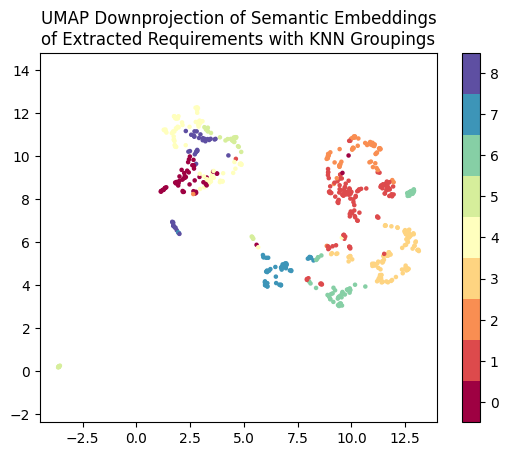

In [12]:
plt.scatter(reducer.embedding_[1:, 0],reducer.embedding_[1:, 1], c=kmeans.labels_[1:], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(10)-0.5).set_ticks(np.arange(9))
plt.title("UMAP Downprojection of Semantic Embeddings\nof Extracted Requirements with KNN Groupings")

## 1-Shot KNN (Seeded Centroid)

In [28]:
rp_defs = [
    "Plan-Net Endpoint\nThe technical details of an endpoint that can be used for electronic services, such as a portal or FHIR REST services, messaging or operations, or DIRECT messaging.",
    "Plan-Net HealthcareService\nThe HealthCareService resource typically describes services offered by an organization/practitioner at a location. The resource may be used to encompass a variety of services covering the entire healthcare spectrum, including promotion, prevention, diagnostics, pharmacy, hospital and ambulatory care, home care, long-term care, and other health-related and community services.",
    "Plan-Net InsurancePlan\nAn InsurancePlan is a discrete package of health insurance coverage benefits that are offered under a particular network type. A given payer’s products typically differ by network type and/or covered benefits. A plan pairs a product’s covered benefits with the particular cost sharing structure offered to a consumer. A given product may comprise multiple plans (i.e. each plan offers different cost sharing requirements for the same set of covered benefits).\n\nInsurancePlan describes a health insurance offering comprised of a list of covered benefits (i.e. the product), costs associated with those benefits (i.e. the plan), and additional information about the offering, such as who it is owned and administered by, a coverage area, contact information, etc.",
    "Plan-Net Location\nA Location is the physical place where healthcare services are provided, practitioners are employed, organizations are based, etc. Locations can range in scope from a room in a building to a geographic region/area.",
    "Plan-Net Network\nA Network refers to a healthcare provider insurance network. A healthcare provider insurance network is an aggregation of organizations and individuals that deliver a set of services across a geography through health insurance products/plans. A network is typically owned by a payer.\n\nIn the PlanNet IG, individuals and organizations are represented as participants in a PLan-Net Network through the practitionerRole and Plan-Net-organizationAffiliation resources, respectively.",
    "Plan-Net Organization\nAn organization is a formal or informal grouping of people or organizations with a common purpose, such as a company, institution, corporation, community group, or healthcare practice. Guidance: When the contact is a department name, rather than a human (e.g., patient help line), include a blank family and given name, and provide the department name in contact.name.text",
    "Plan-Net OrganizationAffiliation\nThe OrganizationAffiliation resource describes relationships between two or more organizations, including the services one organization provides another, the location(s) where they provide services, the availability of those services, electronic endpoints, and other relevant information.",
    "Plan-Net Practitioner\nPractitioner is a person who is directly or indirectly involved in the provisioning of healthcare.",
    "Plan-Net PractitionerRole\nPractionerRole describes details about a provider, which can be a practitioner or an organization. When the provider is a practitioner, there may be a relationship to an organization. A provider renders services to patients at a location. When the provider is a practitioner, there may also be a relationship to an organization. Practitioner participation in healthcare provider insurance networks may be direct or through their role at an organization."
]

rp_embeds = [model.encode(d) for d in rp_defs]

In [16]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(rp_embeds, range(len(rp_embeds)))

KNeighborsClassifier(n_neighbors=1)

In [17]:
knn_preds = knn.predict(X)

In [21]:
cluster_to_inspect = 1

single_cluster = list(filter(lambda x: x[1] == cluster_to_inspect, zip([y['text'] for y in data], knn_preds)))

[x[0] for x in single_cluster]

["Server SHALL support the CodeSystem 'DeliveryMethodCS' with URL 'http://hl7.org/fhir/us/davinci-pdex-plan-net/CodeSystem/DeliveryMethodCS'",
 "The 'service' search parameter for OrganizationAffiliation SHALL reference HealthcareService resources.",
 "The 'location' search parameter for HealthcareService resources SHALL support multiple 'OR' values.",
 "The 'location' search parameter for HealthcareService resources SHALL support multiple 'AND' values.",
 "Servers SHALL support searching for Practitioner resources by given name using the 'given' search parameter.",
 "The 'given' search parameter for Practitioner resources SHALL support multiple 'AND' values.",
 "Servers supporting this guide SHALL support searching for HealthcareService resources using the 'endpoint' search parameter.",
 "The 'endpoint' search parameter for HealthcareService resources SHALL be of type 'reference'.",
 "The 'endpoint' search parameter for HealthcareService resources SHALL support searching by reference 

Text(0.5, 1.0, 'UMAP Downprojection of Semantic Embeddings\nof Extracted Requirements with 1-Shot KNN Generated Groupings')

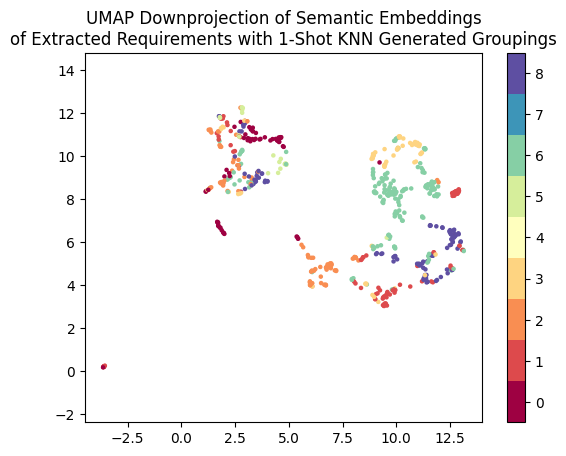

In [19]:
plt.scatter(reducer.embedding_[:, 0],reducer.embedding_[:, 1], c=knn_preds, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(10)-0.5).set_ticks(np.arange(9))
plt.title("UMAP Downprojection of Semantic Embeddings\nof Extracted Requirements with 1-Shot KNN Generated Groupings")

### Centroid-only clustering

In [20]:
groups = []
for _ in rp_defs:
    groups.append(list())
g_labels = []

for x in data:
    distances = [util.pytorch_cos_sim(x['embedding'], y)[0][0] for y in rp_embeds]
    g_labels.append((x['text'], distances.index(min(distances))))
    groups[distances.index(min(distances))].append(x['text'])

In [21]:
rp_defs

['Plan-Net Endpoint\nThe technical details of an endpoint that can be used for electronic services, such as a portal or FHIR REST services, messaging or operations, or DIRECT messaging.',
 'Plan-Net HealthcareService\nThe HealthCareService resource typically describes services offered by an organization/practitioner at a location. The resource may be used to encompass a variety of services covering the entire healthcare spectrum, including promotion, prevention, diagnostics, pharmacy, hospital and ambulatory care, home care, long-term care, and other health-related and community services.',
 'Plan-Net InsurancePlan\nAn InsurancePlan is a discrete package of health insurance coverage benefits that are offered under a particular network type. A given payer’s products typically differ by network type and/or covered benefits. A plan pairs a product’s covered benefits with the particular cost sharing structure offered to a consumer. A given product may comprise multiple plans (i.e. each pla

In [22]:
for g in groups:
    print(len(g))

181
1
26
18
42
46
11
319
7


Text(0.5, 1.0, 'UMAP Downprojection of Semantic Embeddings\nof Extracted Requirements with Centroid Clustering Groupings')

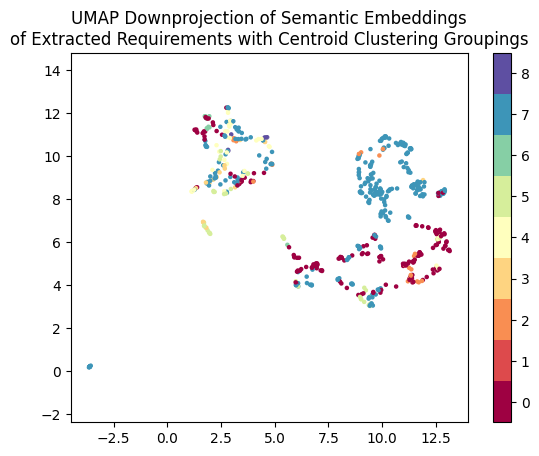

In [23]:
plt.scatter(reducer.embedding_[:, 0],reducer.embedding_[:, 1], c=[x[1] for x in g_labels], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(10)-0.5).set_ticks(np.arange(9))
plt.title("UMAP Downprojection of Semantic Embeddings\nof Extracted Requirements with Centroid Clustering Groupings")

## LLM Based Clustering

In [24]:
with open("Clustered_Requirements_claude1.json") as f:
    llm_groups, llm_labels = json.load(f)

In [32]:
rp_defs

['Plan-Net Endpoint\nThe technical details of an endpoint that can be used for electronic services, such as a portal or FHIR REST services, messaging or operations, or DIRECT messaging.',
 'Plan-Net HealthcareService\nThe HealthCareService resource typically describes services offered by an organization/practitioner at a location. The resource may be used to encompass a variety of services covering the entire healthcare spectrum, including promotion, prevention, diagnostics, pharmacy, hospital and ambulatory care, home care, long-term care, and other health-related and community services.',
 'Plan-Net InsurancePlan\nAn InsurancePlan is a discrete package of health insurance coverage benefits that are offered under a particular network type. A given payer’s products typically differ by network type and/or covered benefits. A plan pairs a product’s covered benefits with the particular cost sharing structure offered to a consumer. A given product may comprise multiple plans (i.e. each pla

In [30]:
llm_groups['<PROFILE_2>']

[["Server SHALL support the CodeSystem 'DeliveryMethodCS' with URL 'http://hl7.org/fhir/us/davinci-pdex-plan-net/CodeSystem/DeliveryMethodCS'",
  '<PROFILE_2>'],
 ["The DeliveryMethodCS CodeSystem SHALL include the code 'virtual' with display 'Virtual' and definition 'Delivery not requiring provider and patient to be physically co-located, such as tele-medicine'",
  '<PROFILE_2>'],
 ["The DeliveryMethodCS CodeSystem SHALL include the code 'physical' with display 'Physical' and definition 'Traditional delivery requiring provider and patient to be physically co-located.'",
  '<PROFILE_2>'],
 ["Servers SHALL support searching for HealthcareService resources by location using the 'location' search parameter.",
  '<PROFILE_2>'],
 ["The 'location' search parameter for HealthcareService resources SHALL support chaining with the following parameters: address, address-postalcode, address-city, address-state, organization, type",
  '<PROFILE_2>'],
 ["The 'location' search parameter for Healthcar

(651, 768)


/Users/jrockhill/miniconda3/envs/ONCL310/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(651, 2)


Text(0.5, 1.0, 'UMAP Downprojection of Semantic Embeddings\nof Extracted Requirements with LLM-Generated Groupings')

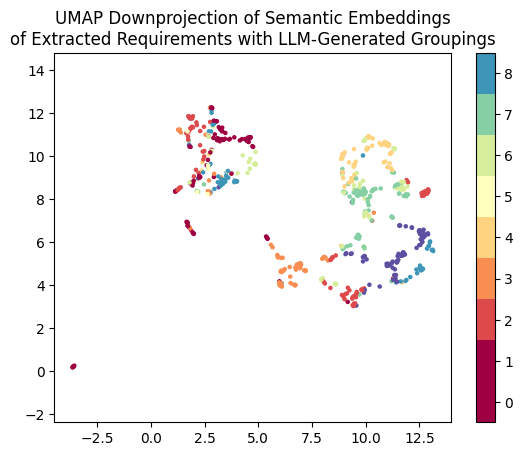

In [25]:
plt.scatter(reducer.embedding_[1:, 0],reducer.embedding_[1:, 1], c=[int(x[-2]) for x in llm_labels], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(10)-0.5).set_ticks(np.arange(9))
plt.title("UMAP Downprojection of Semantic Embeddings\nof Extracted Requirements with LLM-Generated Groupings")

In [ ]:
datakeys = set()
for datum in data:
    datakeys.add(frozenset(datum.keys()))

In [16]:
datakeys

{frozenset({'chunk', 'chunk_index', 'file_name', 'response', 'total_chunks'}),
 frozenset({'chunk',
            'chunk_index',
            'file_name',
            'llm_response',
            'processed_requirements',
            'response',
            'selected_examples',
            'total_chunks'}),
 frozenset({'chunk',
            'chunk_index',
            'file_name',
            'llm_response',
            'processed_requirements',
            'response',
            'selected_examples',
            'total_chunks',
            'unprocessable_requirements'})}

In [27]:
from itertools import product

for x in product(text_to_embed, text_to_embed):
    print(x)
    break

({'text': "Server SHALL support the CodeSystem 'DeliveryMethodCS' with URL 'http://hl7.org/fhir/us/davinci-pdex-plan-net/CodeSystem/DeliveryMethodCS'", 'embedding': [0.00697505846619606, 0.016427630558609962, 0.01356743648648262, -0.006002660840749741, -0.005992749705910683, 0.031453993171453476, 0.028404895216226578, 0.043311625719070435, 0.0025450580287724733, 0.007476839702576399, 0.03057660348713398, 0.007559694815427065, 0.01672084629535675, 0.05317109078168869, 0.015061195008456707, 0.011600960046052933, -0.030413750559091568, 0.05520075559616089, -0.06618881970643997, -0.0505419485270977, -0.016734007745981216, -0.009443833492696285, 0.02026604861021042, -0.041308220475912094, 0.04942717403173447, -0.028837870806455612, -0.03742273896932602, 0.005713489837944508, -0.025584591552615166, -0.060709398239851, 0.04221047833561897, 0.0025893966667354107, 0.06440418213605881, -0.055025700479745865, 1.7966793848245288e-06, -0.03413321077823639, 0.02912859246134758, 0.03975401446223259, 

In [30]:
prod_list = list(product(text_to_embed, text_to_embed))

423801

### Pairwise Embedding Grouping Experiments

In [ ]:
scored_prod_list = [['Requirement1', "Requirement2", "Similarity Score"]]
for i, prod in enumerate(prod_list):
    counter = i+1
    if counter % 10000 == 0:
        print(f"Pair {counter} of {len(prod_list)}")
    if prod[0]['text'] != prod[1]['text']:
        emb0 = prod[0]['embedding']
        emb1 = prod[1]['embedding']
        score = float(util.pytorch_cos_sim(emb0, emb1)[0][0])
        scored_prod_list.append([prod[0]['text'], prod[1]['text'], score])
print(f"Pair {counter} of {len(prod_list)}")

Pair 1000 of 423801
Pair 2000 of 423801
Pair 3000 of 423801
Pair 4000 of 423801
Pair 5000 of 423801
Pair 6000 of 423801
Pair 7000 of 423801
Pair 8000 of 423801
Pair 9000 of 423801
Pair 10000 of 423801
Pair 11000 of 423801
Pair 12000 of 423801
Pair 13000 of 423801
Pair 14000 of 423801
Pair 15000 of 423801
Pair 16000 of 423801
Pair 17000 of 423801
Pair 18000 of 423801
Pair 19000 of 423801
Pair 20000 of 423801
Pair 21000 of 423801
Pair 22000 of 423801
Pair 23000 of 423801
Pair 24000 of 423801
Pair 25000 of 423801
Pair 26000 of 423801
Pair 27000 of 423801
Pair 28000 of 423801
Pair 29000 of 423801
Pair 30000 of 423801
Pair 31000 of 423801
Pair 32000 of 423801
Pair 33000 of 423801
Pair 34000 of 423801
Pair 35000 of 423801
Pair 36000 of 423801
Pair 37000 of 423801
Pair 38000 of 423801
Pair 39000 of 423801
Pair 40000 of 423801
Pair 41000 of 423801
Pair 42000 of 423801
Pair 43000 of 423801
Pair 44000 of 423801
Pair 45000 of 423801
Pair 46000 of 423801
Pair 47000 of 423801
Pair 48000 of 423801
P

In [ ]:
df = pd.DataFrame(scored_prod_list[1:], columns=scored_prod_list[0])
df.head()

,Requirement1,Requirement2,Similarity Score
0,Server SHALL support the CodeSystem 'DeliveryM...,The DeliveryMethodCS CodeSystem SHALL include ...,0.504868
1,Server SHALL support the CodeSystem 'DeliveryM...,The DeliveryMethodCS CodeSystem SHALL include ...,0.520903
2,Server SHALL support the CodeSystem 'DeliveryM...,Servers SHALL support searching OrganizationAf...,0.279096
3,Server SHALL support the CodeSystem 'DeliveryM...,The 'specialty' search parameter for Organizat...,0.252866
4,Server SHALL support the CodeSystem 'DeliveryM...,The 'specialty' search parameter for Organizat...,0.198458


<Axes: >

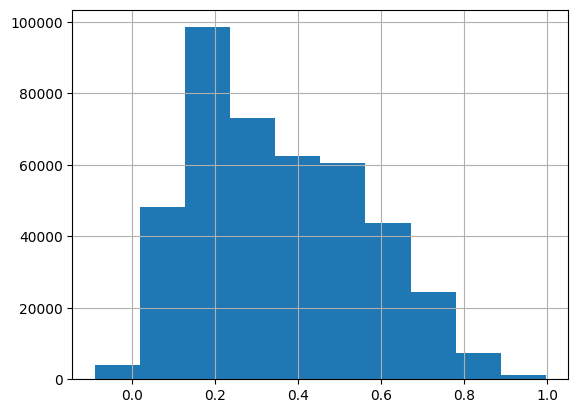

In [44]:
df["Similarity Score"].hist()

In [45]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

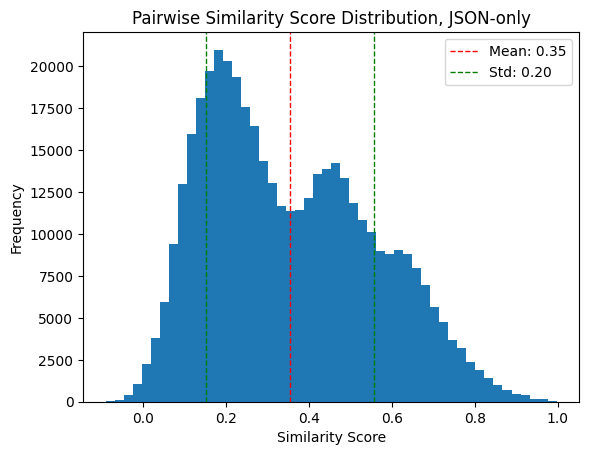

In [58]:
avg = np.mean(df['Similarity Score'])
std = np.std(df['Similarity Score'])

n, bins, patches = plt.hist(df['Similarity Score'], bins=50)

plt.axvline(avg, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {avg:.2f}')
plt.axvline(avg + std, color='g', linestyle='dashed', linewidth=1, label=f'Std: {std:.2f}')
plt.axvline(avg - std, color='g', linestyle='dashed', linewidth=1)
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.title('Pairwise Similarity Score Distribution, JSON-only')
plt.legend()
plt.savefig("jsononlyscores.pdf",bbox_inches="tight")
plt.show()

In [51]:
from scipy import stats

iqr = stats.iqr(df['Similarity Score'])

In [53]:
iqr*2*(df.shape[0]**(1/3))

47.472410139674984

In [59]:
df

,Requirement1,Requirement2,Similarity Score
0,Server SHALL support the CodeSystem 'DeliveryM...,The DeliveryMethodCS CodeSystem SHALL include ...,0.504868
1,Server SHALL support the CodeSystem 'DeliveryM...,The DeliveryMethodCS CodeSystem SHALL include ...,0.520903
2,Server SHALL support the CodeSystem 'DeliveryM...,Servers SHALL support searching OrganizationAf...,0.279096
3,Server SHALL support the CodeSystem 'DeliveryM...,The 'specialty' search parameter for Organizat...,0.252866
4,Server SHALL support the CodeSystem 'DeliveryM...,The 'specialty' search parameter for Organizat...,0.198458
...,...,...,...
422983,The Extension SHALL NOT have a value[x],Extension:daysOfWeek.value[x] SHALL be bound t...,0.378213
422984,The Extension SHALL NOT have a value[x],Extension:allDay SHALL have a value[x] of type...,0.524188
422985,The Extension SHALL NOT have a value[x],Extension:availableStartTime SHALL have a valu...,0.480116
422986,The Extension SHALL NOT have a value[x],Extension:availableEndTime SHALL have a value[...,0.519040


In [60]:
df.to_csv("requirement_similarity.csv")

In [6]:
df = pd.read_csv("requirement_similarity.csv").iloc[:,1:]

In [7]:
df.head()

,Requirement1,Requirement2,Similarity Score
0,Server SHALL support the CodeSystem 'DeliveryM...,The DeliveryMethodCS CodeSystem SHALL include ...,0.504868
1,Server SHALL support the CodeSystem 'DeliveryM...,The DeliveryMethodCS CodeSystem SHALL include ...,0.520903
2,Server SHALL support the CodeSystem 'DeliveryM...,Servers SHALL support searching OrganizationAf...,0.279096
3,Server SHALL support the CodeSystem 'DeliveryM...,The 'specialty' search parameter for Organizat...,0.252866
4,Server SHALL support the CodeSystem 'DeliveryM...,The 'specialty' search parameter for Organizat...,0.198458


In [10]:
df.shape

(422988, 3)

In [8]:
df.drop_duplicates(subset=['Requirement1', 'Requirement2'])

,Requirement1,Requirement2,Similarity Score
0,Server SHALL support the CodeSystem 'DeliveryM...,The DeliveryMethodCS CodeSystem SHALL include ...,0.504868
1,Server SHALL support the CodeSystem 'DeliveryM...,The DeliveryMethodCS CodeSystem SHALL include ...,0.520903
2,Server SHALL support the CodeSystem 'DeliveryM...,Servers SHALL support searching OrganizationAf...,0.279096
3,Server SHALL support the CodeSystem 'DeliveryM...,The 'specialty' search parameter for Organizat...,0.252866
4,Server SHALL support the CodeSystem 'DeliveryM...,The 'specialty' search parameter for Organizat...,0.198458
...,...,...,...
422983,The Extension SHALL NOT have a value[x],Extension:daysOfWeek.value[x] SHALL be bound t...,0.378213
422984,The Extension SHALL NOT have a value[x],Extension:allDay SHALL have a value[x] of type...,0.524188
422985,The Extension SHALL NOT have a value[x],Extension:availableStartTime SHALL have a valu...,0.480116
422986,The Extension SHALL NOT have a value[x],Extension:availableEndTime SHALL have a value[...,0.519040


In [15]:
subdf = df.loc[:,['Requirement1', 'Requirement2']]

dupes = subdf.T.apply(sorted).T.duplicated()

deduped = df[~dupes]

deduped.head()

,Requirement1,Requirement2,Similarity Score
0,Server SHALL support the CodeSystem 'DeliveryM...,The DeliveryMethodCS CodeSystem SHALL include ...,0.504868
1,Server SHALL support the CodeSystem 'DeliveryM...,The DeliveryMethodCS CodeSystem SHALL include ...,0.520903
2,Server SHALL support the CodeSystem 'DeliveryM...,Servers SHALL support searching OrganizationAf...,0.279096
3,Server SHALL support the CodeSystem 'DeliveryM...,The 'specialty' search parameter for Organizat...,0.252866
4,Server SHALL support the CodeSystem 'DeliveryM...,The 'specialty' search parameter for Organizat...,0.198458


In [ ]:
cutoffs = [0.8, 0.85, 0.9, 0.95]
reqs = deduped.Requirement1.unique()
for cutoff in cutoffs:
    subdf = deduped[deduped["Similarity Score"].astype(float) >= cutoff]
    group_map = {}
    for req in reqs:
        group_actions = subdf[(subdf.Requirement1 == req)|(subdf.Requirement2 == req)]
        if group_actions.shape[0] == 0:
            group_map[req] = set([req])
        else:
            for _, group_action in group_actions.iterrows():
                if (group_action.Requirement1 in group_map) and not (group_action.Requirement2 in group_map):
                    group_to_update = 
        

In [22]:
group_actions


,Requirement1,Requirement2,Similarity Score
